# Part Two: Avocado Pricing and Supply Using Mathematical Optimization 

This is a second part of an example on price optimization: [How Much Is Too Much? Avocado Pricing and Supply Using Mathematical Optimization](https://github.com/Gurobi/modeling-examples/tree/master/price_optimization)

In the first part, an ordinary linear regression model (OLS) was used to establish the relationship between price and demand based on data from the.... Part Two replaces the OLS model with a trained `Scikit-learn` model and uses the [Gurobi Machine Learning](https://gurobi-machinelearning.readthedocs.io/en/stable/#) package to embed it in a Gurobi optimization model.

In this example, we will also use `gurobipy-pandas`, which is another Gurobi open-source package and serves as a convenient (and optional) wrapper to connect pandas with gurobipy. 

If you are already familiar with the example from the other notebook, you can
jump directly to [building the regression model](#Part-2:-Predict-the-Sales)
and then to [formulating the optimization problem](#Part-3:-Optimize-for-Price-and-Supply-of-Avocados).

**Goal**: Develop a data science and decision-making pipeline for pricing and distribution of avocados to maximize revenue.

To accomplish this, the notebook will walk trough three stages:

1. A quick review of the [Hass Avocado Board](https://hassavocadoboard.com/) (HAB) data
2. Build a prediction model for avocado demand as a function of price, region, year and seasonality.
3. Design an optimization model that sets the optimal price and supply quantity to maximize the net revenue while incorporating transportation and costs.

## Load the Packages and Prepare the Dataset

Just as in the first example, we use real HAB sales data. 


In [1]:
import pandas as pd
import warnings
import numpy as np

The dataset from HAB contains sales data for the years 2019-2022. This data is augmented by a previous download from HAB available on
[Kaggle](https://www.kaggle.com/datasets/timmate/avocado-prices-2020) with sales for the years 2015-2018.

This notebook will skip a lot of the preprocessing from the first version of this example.

In [2]:
data_url = "https://raw.githubusercontent.com/Gurobi/modeling-examples/master/price_optimization/"
avocado = pd.read_csv(data_url+"HAB_data_2015to2022.csv")
avocado["date"] = pd.to_datetime(avocado["date"])
avocado = avocado.sort_values(by="date")
avocado

,date,units_sold,price,region,year,month,peak
0,2015-01-04,3.382800,1.020000,Great_Lakes,2015,1,0
1,2015-01-04,2.578275,1.100000,Midsouth,2015,1,0
2,2015-01-04,5.794411,0.890000,West,2015,1,0
3,2015-01-04,3.204112,0.980000,Southeast,2015,1,0
4,2015-01-04,0.321824,1.050000,Northern_New_England,2015,1,0
...,...,...,...,...,...,...,...
3396,2022-05-15,0.445830,1.513707,Northern_New_England,2022,5,1
3397,2022-05-15,4.150433,1.269883,SouthCentral,2022,5,1
3398,2022-05-15,4.668815,1.644873,Northeast,2022,5,1
3399,2022-05-15,32.745321,1.527357,Total_US,2022,5,1


One of the regions in the above data frame is `Total_US`, so we can create a list of regions, excluding the total, which can be used to subset the data now. It'll be used later in the example as well.

In [7]:
regions = [
    "Great_Lakes",
    "Midsouth",
    "Northeast",
    "Northern_New_England",
    "SouthCentral",
    "Southeast",
    "West",
    "Plains"
]
df = avocado[avocado.region.isin(regions)]

## Predict the Sales

In the first instance of this example, further analysis was done on the input data along with a few visualizations. Here, we will go directly to the predicive model training, starting with a random split of the dataset into $80\%$ training and $20\%$ testing data.

In [18]:
from sklearn.model_selection import train_test_split

X = df[["region", "price", "year", "peak"]]
y = df["units_sold"]
# Split the data for training and testing
X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=0.8, random_state=1
)
X

,region,price,year,peak
0,Great_Lakes,1.020000,2015,0
1,Midsouth,1.100000,2015,0
2,West,0.890000,2015,0
3,Southeast,0.980000,2015,0
4,Northern_New_England,1.050000,2015,0
...,...,...,...,...
3395,Great_Lakes,1.557276,2022,1
3396,Northern_New_England,1.513707,2022,1
3397,SouthCentral,1.269883,2022,1
3398,Northeast,1.644873,2022,1


Note that the region is a categorical variable and we will transform that variable using Scikit Learn's `OneHotEncoder`. We also use a standard scaler for prices and year index, combining all of the ese with `Column Transformer` built using `make_column_transformer`.

In [63]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import make_column_transformer
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.metrics import r2_score

feat_transform = make_column_transformer(
    (OneHotEncoder(drop="first"), ["region"]),
    (StandardScaler(), ["price", "year"]),
    ("passthrough", ["peak"]),
    verbose_feature_names_out=False,
    remainder='drop'
)

The regression model is a pipeline consisting of the `Column Transformer` and the type of model we want to use for the regression. For comparison, we'll stick with a linear regression.

In [92]:
reg = make_pipeline(feat_transform, LinearRegression())
# print(reg[0])
print(reg[0].fit_transform(X_train)[0])
# print(reg[1])
print(reg[1])
reg.fit(X_train, y_train)
print("Coefficients of linear regression model: ", reg["linearregression"].coef_)
# Get R^2 from test data
y_pred = reg.predict(X_test)
print(f"The R^2 value in the test set is {np.round(r2_score(y_test, y_pred),5)}")
# reg.predict(X_test)

[ 0.          0.          0.          0.          0.          1.
  0.         -0.93401449  0.37355294  0.        ]
LinearRegression()
Coefficients of linear regression model:  [-0.22950618  1.43686311 -3.03386368 -1.80251477  1.69574838  0.55956786
  2.61374061 -0.47692154  0.3375303   0.55769518]
The R^2 value in the test set is 0.9083


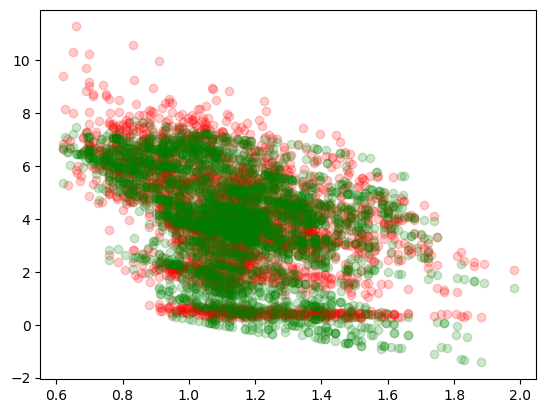

In [29]:
import matplotlib.pyplot as plt
plt.plot(X["price"], y, 'ro', label="observation", alpha=0.2)
plt.plot(X["price"], reg.predict(X), 'go', label="observation", alpha=0.2)
plt.show()

We can observe a good $R^2$ value in the test set. We will now train the fit to the full dataset.

In [30]:
reg.fit(X, y)

y_pred_full = reg.predict(X)
print(f"The R^2 value in the full dataset is {np.round(r2_score(y, y_pred_full),5)}")

The R^2 value in the full dataset is 0.90667


## Optimize for Price and Supply of Avocados

Here is a quick review of notation for the formulation of the mathematical optimization model. The subscript $r$ will be used to denote each region.
### Input parameters
- $d(p,r)$: predicted demand in region $r$ when the avocado price is $p$
- $B$: available avocados to be distributed across the regions
- $c_{waste}$: cost ($\$$) per wasted avocado
- $c^r_{transport}$: cost ($\$$) of transporting a avocado to region $r$
- $a_{min},a_{max}$: minimum and maximum price ($\$$) per avocado
  $r$
- $b^r_{min},b^r_{max}$: minimum and maximum number of avocados allocated to region $r$

The following code sets values for these parameters. Feel free to adjust these to see how the aolution to the optimization model will change.


In [31]:
# Sets and parameters
B = 35  # total amount of avocado supply

peak_or_not = 1  # 1 if it is the peak season; 0 if isn't
year = 2022

c_waste = 0.1  # the cost ($) of wasting an avocado

# the cost of transporting an avocado
c_transport = pd.Series(
    {
        "Great_Lakes": 0.3,
        "Midsouth": 0.1,
        "Northeast": 0.4,
        "Northern_New_England": 0.5,
        "SouthCentral": 0.3,
        "Southeast": 0.2,
        "West": 0.2,
        "Plains": 0.2,
    }, name='transport_cost'
)
c_transport = c_transport.loc[regions]

a_min = 0  # minimum avocado price 
a_max = 3  # maximum avocado price

# Get the lower and upper bounds from the dataset for the price and the number of products to be stocked
data = pd.concat([c_transport,
                  df.groupby("region")["units_sold"].min().rename('min_delivery'),
                  df.groupby("region")["units_sold"].max().rename('max_delivery')], axis=1)

data

,transport_cost,min_delivery,max_delivery
Great_Lakes,0.3,2.063574,7.094765
Midsouth,0.1,1.845443,6.168572
Northeast,0.4,2.364424,8.836406
Northern_New_England,0.5,0.219690,0.917984
SouthCentral,0.3,3.687130,10.323175
Southeast,0.2,2.197764,7.810475
West,0.2,3.260102,11.274749
Plains,0.2,1.058938,3.575499


#### Install and import Gurobi packages

In [83]:
%pip install gurobipy_pandas
%pip install gurobi-machinelearning
import gurobipy_pandas as gppd
from gurobi_ml import add_predictor_constr

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


### Create dataframe for the fixed features of the regression

We now start creating the input of the regression in the optimization models with the features that are fixed.

We use gurobipy-pandas that help to more easily create gurobipy models using pandas data.

First, create a dataframe with the features that are fixed in our optimization problem.
It is indexed by the regions (we want to use one regression to predict demand for each region) and has the 3
columns corresponding to the fixed features:

* `year`
* `peak` with the value of `peak_or_not`
* `region` that repeat the names of the regions.

Let's display the dataframe to make sure it is correct.

In [32]:
feats = pd.DataFrame(
    data={
        "year": year,
        "peak": peak_or_not,
        "region": regions,
    },
    index=regions
)
feats

,year,peak,region
Great_Lakes,2022,1,Great_Lakes
Midsouth,2022,1,Midsouth
Northeast,2022,1,Northeast
Northern_New_England,2022,1,Northern_New_England
SouthCentral,2022,1,SouthCentral
Southeast,2022,1,Southeast
West,2022,1,West
Plains,2022,1,Plains


In [98]:
arcs = gp.tuplelist()
arcs.append((1,2))
arcs.append((2,3))
arcs

<gurobi.tuplelist (2 tuples, 2 values each):
 ( 1 , 2 )
 ( 2 , 3 )
>

### Decision Variables

Let us now define the decision variables. In our model, we want to store the
price and number of avocados allocated to each region. We also want variables
that track how many avocados are predicted to be sold and how many are predicted
to be wasted. The following notation is used to model these decision variables.

- $p$ the price of an avocado ($\$$) in each region
- $x$ the number of avocados supplied to each region
- $s$ the predicted number of avocados sold in each region
- $w$ the predicted number of avocados wasted in each region
- $d$ the predicted demand in each region

All those variables are created using gurobipy-pandas, with the function `gppd.add_vars` they are given the same index as the `data` dataframe.

In [99]:
import gurobipy as gp

m = gp.Model("Avocado_Price_Allocation")

price = gppd.add_vars(m, data, name="price", lb=a_min, ub=a_max) # price of an avocado for each region
x = gppd.add_vars(m, data, name="x", lb='min_delivery', ub='max_delivery') # number of avocados supplied to each reagion
s = gppd.add_vars(m, data, name="s") # predicted amount of sales in each region for the given price
w = gppd.add_vars(m, data, name="w") # excess wasteage in each region
demand = gppd.add_vars(m, data, lb=-gp.GRB.INFINITY, name="demand") # Add variables for the regression

m.update()

# Display one of the variables
print(price)
print("="*30)
print(demand)

Great_Lakes                      <gurobi.Var price[Great_Lakes]>
Midsouth                            <gurobi.Var price[Midsouth]>
Northeast                          <gurobi.Var price[Northeast]>
Northern_New_England    <gurobi.Var price[Northern_New_England]>
SouthCentral                    <gurobi.Var price[SouthCentral]>
Southeast                          <gurobi.Var price[Southeast]>
West                                    <gurobi.Var price[West]>
Plains                                <gurobi.Var price[Plains]>
Name: price, dtype: object
Great_Lakes                      <gurobi.Var demand[Great_Lakes]>
Midsouth                            <gurobi.Var demand[Midsouth]>
Northeast                          <gurobi.Var demand[Northeast]>
Northern_New_England    <gurobi.Var demand[Northern_New_England]>
SouthCentral                    <gurobi.Var demand[SouthCentral]>
Southeast                          <gurobi.Var demand[Southeast]>
West                                    <gurobi.Var deman

### Add the Supply Constraint

We now introduce the constraints. The first constraint is to make sure that the
total number of avocados supplied is equal to $B$, which can be mathematically
expressed as follows.

\begin{align*} \sum_{r} x_r &= B \end{align*}


In [38]:
m.addConstr(x.sum() == B)
m.update()

### Add Constraints That Define Sales Quantity

As a quick reminder, the sales quantity is the minimum of the allocated quantity and the predicted demand, i.e., $s_r = \min \{x_r,d_r(p_r)\}$ This relationship can be modeled by the following two constraints for each region $r$.

\begin{align*} s_r &\leq x_r  \\
s_r &\leq d(p_r,r) \end{align*}

In this case, we use gurobipy-pandas `add_constrs` function, which is intuitive to use given the inequalities above.

In [39]:
gppd.add_constrs(m, s, gp.GRB.LESS_EQUAL, x)
gppd.add_constrs(m, s, gp.GRB.LESS_EQUAL, demand)
m.update()

### Add the Wastage Constraints

Finally, we should define the predicted wastage in each region, given by the
supplied quantity that is not predicted to be sold. We can express this
mathematically for each region $r$.

\begin{align*} w_r &= x_r - s_r \end{align*}

In [40]:
gppd.add_constrs(m, w, gp.GRB.EQUAL, x - s)
m.update()

### Add the constraints to predict demand
First, we create our full input for the predictor constraint. We concatenate the `p` variables and the fixed features. Remember that the predicted price is a function of region, year, and peak/off-peak season.

In [74]:
feats

,year,peak,region
Great_Lakes,2022,1,Great_Lakes
Midsouth,2022,1,Midsouth
Northeast,2022,1,Northeast
Northern_New_England,2022,1,Northern_New_England
SouthCentral,2022,1,SouthCentral
Southeast,2022,1,Southeast
West,2022,1,West
Plains,2022,1,Plains


In [54]:
m_feats = pd.concat([feats, price], axis=1)[["region", "price", "year", "peak"]]
m_feats

,region,price,year,peak
Great_Lakes,Great_Lakes,<gurobi.Var price[Great_Lakes]>,2022,1
Midsouth,Midsouth,<gurobi.Var price[Midsouth]>,2022,1
Northeast,Northeast,<gurobi.Var price[Northeast]>,2022,1
Northern_New_England,Northern_New_England,<gurobi.Var price[Northern_New_England]>,2022,1
SouthCentral,SouthCentral,<gurobi.Var price[SouthCentral]>,2022,1
Southeast,Southeast,<gurobi.Var price[Southeast]>,2022,1
West,West,<gurobi.Var price[West]>,2022,1
Plains,Plains,<gurobi.Var price[Plains]>,2022,1


Now, we just call
[add_predictor_constr](https://gurobi-machinelearning.readthedocs.io/en/stable/api/AbstractPredictorConstr.html#gurobi_ml.add_predictor_constr)
to insert the constraints linking the features and the demand into the model `m`.

It is important that you keep the columns in the order above, otherwise you will see an error. The columns must be in the same order as the training data. 

In [55]:
pred_constr = add_predictor_constr(m, reg, m_feats, demand)
pred_constr.print_stats()

Model for pipe4:
88 variables
24 constraints
Input has shape (8, 4)
Output has shape (8, 1)

Pipeline has 2 steps:

--------------------------------------------------------------------------------
Step            Output Shape    Variables              Constraints              
                                                Linear    Quadratic      General
col_trans            (8, 10)           24           16            0            0

lin_reg               (8, 1)           64            8            0            0

--------------------------------------------------------------------------------


### Set the Objective

The goal is to maximize the **net revenue**, which is the product of price and quantity, minus costs over all regions. This model assumes the purchase costs are fixed (since the amount $B$ is fixed) and are therefore not incorporated.

Using the defined decision variables, the objective can be written as follows.

\begin{align} \textrm{maximize} &  \sum_{r}  (p_r * s_r - c_{waste} * w_r -
c^r_{transport} * x_r)& \end{align}

In [56]:
m.setObjective((price * s).sum() - c_waste * w.sum() - (c_transport * x).sum(),
               gp.GRB.MAXIMIZE)

In [77]:
m.getObjective()

<gurobi.QuadExpr: -0.3 x[Great_Lakes] + -0.1 x[Midsouth] + -0.4 x[Northeast] + -0.5 x[Northern_New_England] + -0.3 x[SouthCentral] + -0.2 x[Southeast] + -0.2 x[West] + -0.2 x[Plains] + -0.1 w[Great_Lakes] + -0.1 w[Midsouth] + -0.1 w[Northeast] + -0.1 w[Northern_New_England] + -0.1 w[SouthCentral] + -0.1 w[Southeast] + -0.1 w[West] + -0.1 w[Plains] + [ price[Great_Lakes] * s[Great_Lakes] + price[Midsouth] * s[Midsouth] + price[Northeast] * s[Northeast] + price[Northern_New_England] * s[Northern_New_England] + price[SouthCentral] * s[SouthCentral] + price[Southeast] * s[Southeast] + price[West] * s[West] + price[Plains] * s[Plains] ]>

### Fire Up the Solver

In our model, the objective is **quadratic** since we take the product of price
and the predicted sales, both of which are variables. Maximizing a quadratic
term is said to be **non-convex**, and we specify this by setting the value of
the [Gurobi NonConvex
parameter](https://www.gurobi.com/documentation/10.0/refman/nonconvex.html) to be
$2$.

In [53]:
m.Params.NonConvex = 2
m.optimize()

Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (mac64[rosetta2])

CPU model: Apple M1 Pro
Thread count: 10 physical cores, 10 logical processors, using up to 10 threads



GurobiError: Model too large for size-limited license; visit https://www.gurobi.com/free-trial for a full license

The solver solved the optimization problem in less than a second. Let us now
analyze the optimal solution by storing it in a Pandas dataframe.

In [22]:
solution = pd.DataFrame(index=regions)

solution["Price"] = price.gppd.X
solution["Allocated"] = x.gppd.X
solution["Sold"] = s.gppd.X
solution["Wasted"] = w.gppd.X
solution["Pred_demand"] = demand.gppd.X

opt_revenue = m.ObjVal
print("\n The optimal net revenue: $%f million" % opt_revenue)
solution.round(4)


 The optimal net revenue: $41.877461 million


,Price,Allocated,Sold,Wasted,Pred_demand
Great_Lakes,1.6639,3.4464,3.4464,0.0000,3.4464
Midsouth,1.5588,6.1686,3.4353,2.7333,3.4353
Northeast,2.0390,4.0527,4.0527,0.0000,4.0527
Northern_New_England,1.4412,0.9180,0.9180,0.0000,0.9180
SouthCentral,2.0527,4.3033,4.3033,0.0000,4.3033
Southeast,1.7464,3.8486,3.8486,0.0000,3.8486
West,2.2042,9.6133,4.8575,4.7558,4.8575
Plains,1.2021,2.6491,2.6491,0.0000,2.6491


We can also check the error in the estimate of the Gurobi solution for the regression model.

In [23]:
print(
    "Maximum error in approximating the regression {:.6}".format(
        np.max(pred_constr.get_error())
    )
)

Maximum error in approximating the regression 1.77636e-15


This was in introductory look at using the Gurobi Machine Learning package. For more on this example, see the [Price Optimization example of Github](https://github.com/Gurobi/modeling-examples/tree/master/price_optimization)
as well as how to work with the model interactively.

Copyright © 2023 Gurobi Optimization, LLC